**Mining dataset**

**Load the dataset**

In [176]:
import pandas as pd

X_train = pd.read_csv("training_set_values.csv")
Y_train = pd.read_csv("training_set_labels.csv")

**Data analysis and Pre-processing**

In [177]:
#display percentage of null values

null_values = round(X_train.isna().sum()*100/len(X_train), 1).sort_values(ascending = False)
zero_values = round(X_train.isin([0]).sum()*100/len(X_train), 1).sort_values(ascending = False)

print()
print(null_values.head(7))
print(zero_values.head(7))


scheme_name          47.4
scheme_management     6.5
installer             6.2
funder                6.1
public_meeting        5.6
permit                5.1
subvillage            0.6
dtype: float64
num_private          98.7
amount_tsh           70.1
population           36.0
construction_year    34.9
gps_height           34.4
permit               29.4
public_meeting        8.5
dtype: float64


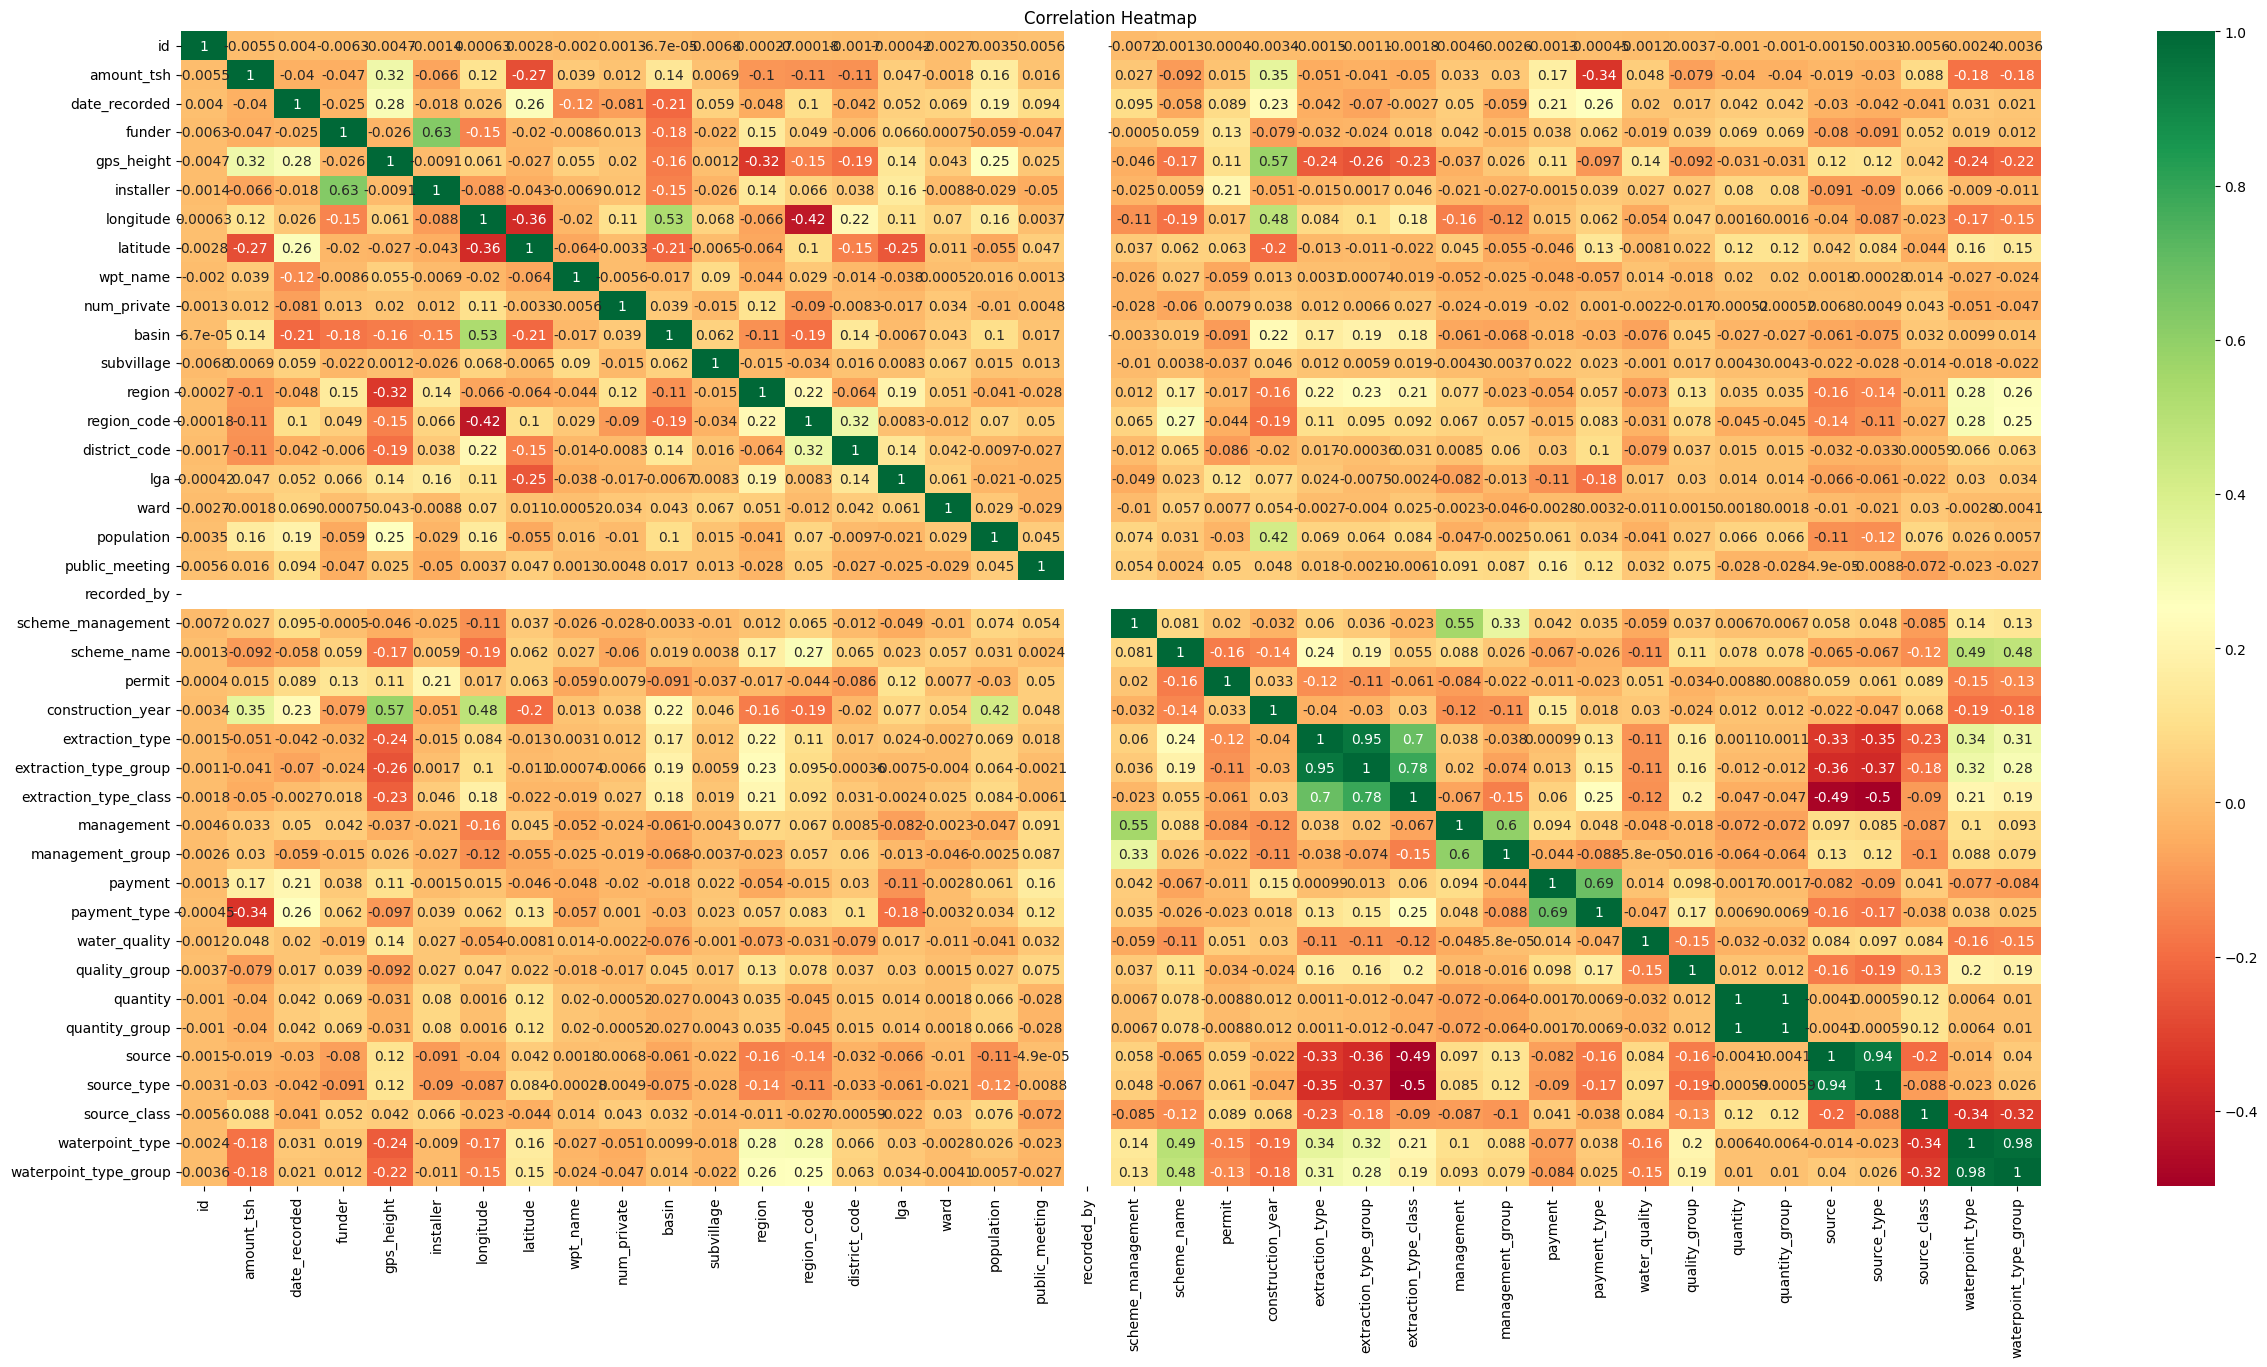

In [178]:
# display the correlation matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = pd.DataFrame()
encoder = LabelEncoder()
for col in X_train.columns:
    correlation_matrix[col] = encoder.fit_transform(X_train[col])
    
# Check feature correlation of all variables
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix.corr(), annot=True, cmap='RdYlGn')
plt.title('Correlation Heatmap')
plt.show()

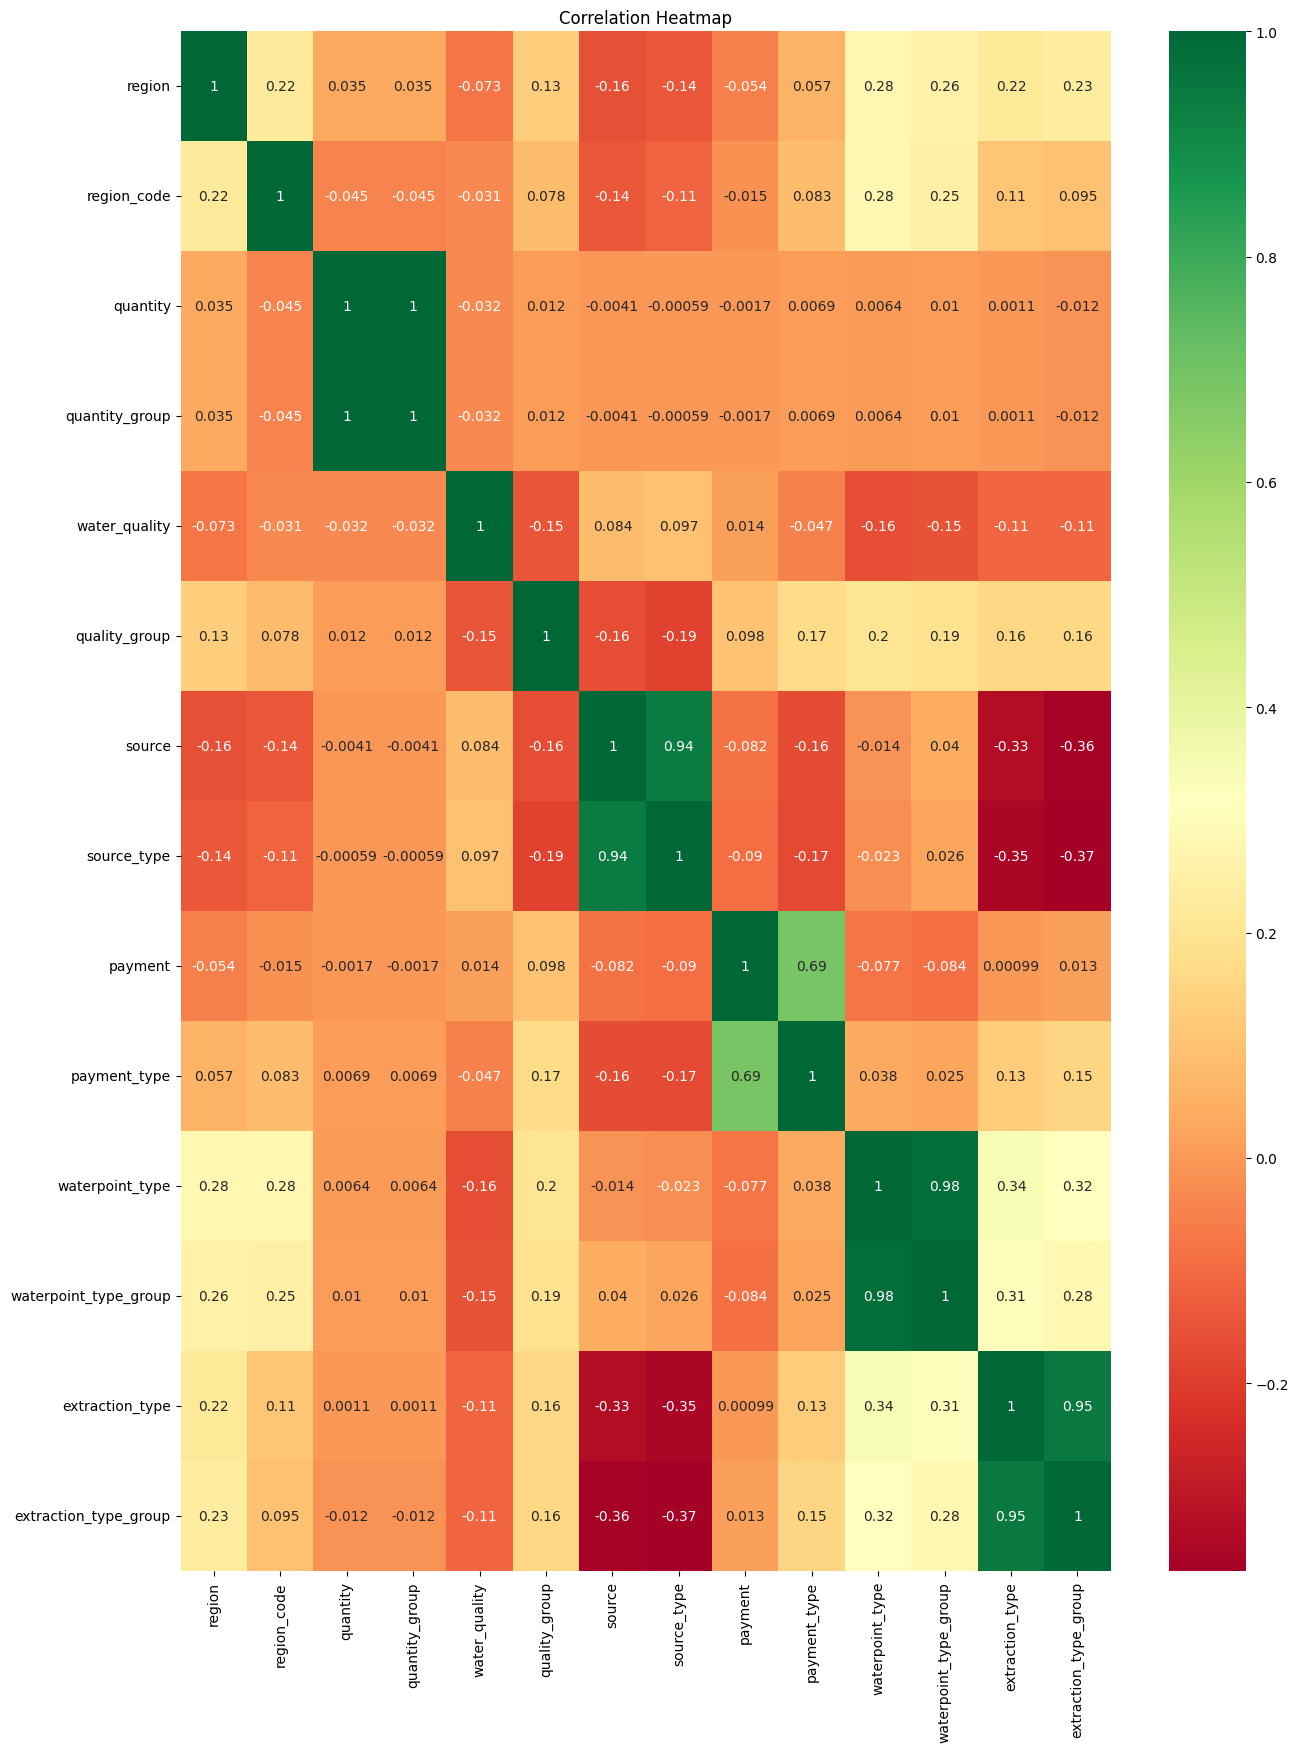

In [179]:
# Zoom in on columns with high feature correlation
plt.figure(figsize=(15, 20))
sns.heatmap(correlation_matrix[["region", "region_code", "quantity", "quantity_group", "water_quality", "quality_group", "source", "source_type", "payment", "payment_type", "waterpoint_type", "waterpoint_type_group", "extraction_type", "extraction_type_group"]].corr(), annot=True, cmap='RdYlGn')
plt.title('Correlation Heatmap')
plt.show()

In [180]:
# delete columns with:
# no use as a feature: "id"
# high number of zero and null values: "amount_tsh", "num_private"
# high correlation with another column: "region", "quantity_group", "quality_group", "source_type", "payment_type", "waterpoint_type_group", "scheme_name"

X_train.drop(["id", "amount_tsh", "num_private", "region", "quantity_group", "quality_group", "source_type", "payment_type", "waterpoint_type_group", "scheme_name"], axis = 1, inplace=True)
Y_train.drop("id", axis=1, inplace= True)

In [181]:
# impute values using mean
# these 4 column is imputed using the mean of datas with same region code
columns_to_impute = ["longitude", "latitude", "gps_height", "population"]
df_mean = X_train.groupby(["region_code"])[columns_to_impute].mean()
for column in columns_to_impute:
    for (index, row) in X_train.loc[X_train[column] == 0].iterrows():
        X_train.loc[index, column] = df_mean.loc[row["region_code"]][column]

# this column imputed using the mean of the column
X_train.loc[X_train[X_train["construction_year"].isin([0])].index, ["construction_year"]] = X_train["construction_year"].mean()

In [182]:
#display percentage of null values after column removal and imputation
print(f"null values percentage before imputation: {null_values.mean()}")
print(f"zero values percentage before imputation: {zero_values.mean()}")

null_values = round(X_train.isna().sum()*100/len(X_train), 1)
zero_values = round(X_train.isin([0]).sum()*100/len(X_train), 1)

print(f"null values percentage after imputation: {null_values.mean()}")
print(f"zero values percentage after imputation: {zero_values.mean()}")

null values percentage before imputation: 1.9375
zero values percentage before imputation: 7.8775
null values percentage after imputation: 1.0033333333333332
zero values percentage after imputation: 2.25


In [183]:
# extract subfeatures from date
date_recorded, month_recorded, year_recorded = [], [], []
for cell in X_train["date_recorded"]:
    conversion = cell.split("-")
    date_recorded.append(int(conversion[2]))
    month_recorded.append(int(conversion[1]))
    year_recorded.append(int(conversion[0]))
X_train["date_recorded"] = date_recorded
X_train["month_recorded"] = month_recorded
X_train["year_recorded"] = year_recorded

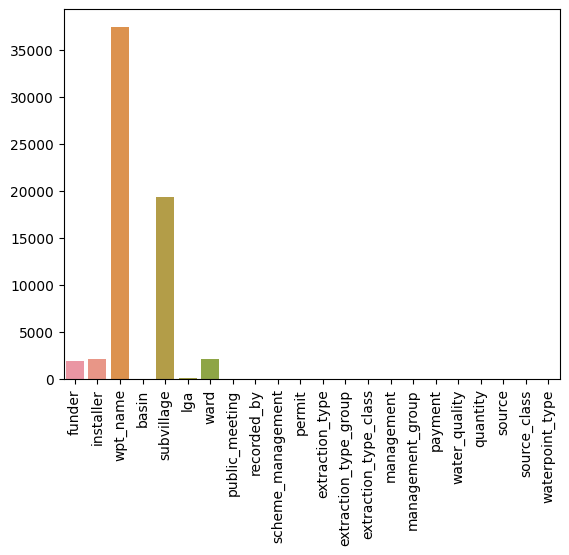

In [184]:
# count unique values on each columns
value_counts = pd.DataFrame()
for col in [col for col in X_train.columns if X_train[col].dtypes == "O"]:
    value_counts[col] = [len(X_train[col].unique())]
plot = sns.barplot(data=value_counts)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

In [185]:
# replace values that occurs less than 100 times

for col in [col for col in X_train.columns if X_train[col].dtypes == "O"]:
    value_to_replace = X_train[col].value_counts()[X_train[col].value_counts() < 100].index
    X_train.loc[X_train[col].isin(value_to_replace), [col]] = "other"

In [186]:
# encode all columns that have non numeric values type
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
for col in [col for col in X_train.columns if X_train[col].dtypes == "O"]:
    X_train[col] = encode.fit_transform(X_train[col])

for col in [col for col in Y_train.columns if Y_train[col].dtypes == "O"]:
    Y_train[col] = encode.fit_transform(Y_train[col])

In [187]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from time import time

# build the parameter grid
parameters = {"n_estimators": [2, 5, 10, 20, 50, 100],
                "min_samples_leaf": np.arange(1, 11)}

# build the cross validator
SKF = StratifiedKFold(n_splits=5, shuffle= True)

# build the ensemble
rf_model = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv=SKF, verbose = 2, n_jobs= -1)

# build the model and record time
timestamp = time()
rf_model.fit(X_train, Y_train)
timestamp = time() - timestamp

Fitting 5 folds for each of 60 candidates, totalling 300 fits


d:\Softwares\Python310\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [188]:
#print parameter, score, and time
print(f"best parameter combination          : {rf_model.best_params_}")
print(f"best score                          : {rf_model.best_score_}")
print(f"time required to build the model    : {timestamp} s")

best parameter combination          : {'min_samples_leaf': 2, 'n_estimators': 100}
best score                          : 0.813973063973064
time required to build the model    : 130.20871829986572 s


In [190]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from fancyimpute import IterativeImputer
# load dataset
X_trains = pd.read_csv('training_set_values.csv')
X_labels = pd.read_csv('training_set_labels.csv')
X_trains = X_trains.replace(0, np.nan)

In [191]:
# date_recorded is a date feature that the machine learning model does not handle directly, so here we refine it. This is done by splitting it into year, month and day
# Convert the "date_recorded" column to a datetime type
X_trains['date_recorded'] = pd.to_datetime(X_trains['date_recorded'], format='%Y-%m-%d')
# Withdrawal of year, month and day
X_trains['year'] = X_trains['date_recorded'].dt.year
X_trains['month'] = X_trains['date_recorded'].dt.month
X_trains['day'] = X_trains['date_recorded'].dt.day

In [192]:
# Discard features with high correlation, such as region_code and district_code, which have a correlation of 0.68. Both of these features are geographical location information, so we can remove one of them. 
# Discard features that have multicollinearity, such as waterpoint_type and waterpoint_type_group, which have a correlation of 1, so we can delete one of the features.
# Discard features with high cardinality, such as wpt_name
drop_features = ['wpt_name','subvillage','id','date_recorded','district_code', 'extraction_type_group', 'quantity_group', 'source_type', 'waterpoint_type_group', 'installer', 'extraction_type_class','payment_type', 'management_group']
X_trains = X_trains.drop(drop_features, axis=1)

In [193]:
# Here the processing of non-numeric features begins, bringing the dataset into a format that the model can handle
# Get the name of every feature in the dataset that is of type object
object_columns = []
for columnName in X_trains.columns:
    if X_trains[columnName].dtype == "object":
        object_columns.append(columnName)
        
# Encode Categorical Columns using LabelEncoder
for column in object_columns:
    myEncoder = LabelEncoder()
    X_trains[column] = myEncoder.fit_transform(X_trains[column])

In [194]:
# Since the longitude, gps_height and population of the location are region dependent, the missing values are replaced using the following method
# Replace longitute with median based on region_code grouping
geo_median = X_trains.groupby(['region_code'])[['latitude', 'longitude']].median()

nan_longitude_mask = X_trains['longitude'].isna()
nan_longitude_indices = X_trains.loc[nan_longitude_mask].index
X_trains.loc[nan_longitude_indices, 'longitude'] = X_trains.loc[nan_longitude_indices, 'region_code'].map(geo_median['longitude'])
# Replace gps_height and population with mean value based on region_code grouping
district_mean = X_trains.groupby('region_code')[['gps_height', 'population']].mean()

X_trains['gps_height'] = X_trains.groupby('region_code')['gps_height'].apply(lambda x: x.fillna(x.mean()))
X_trains['population'] = X_trains.groupby('region_code')['population'].apply(lambda x: x.fillna(x.mean()))

# Use Multiple Imputation by Chained Equations for the remaining missing values
mice_method_imputer = IterativeImputer()
X_trains = pd.DataFrame(mice_method_imputer.fit_transform(X_trains), columns = X_trains.columns)

C:\Users\Steven K. Chandra\AppData\Local\Temp\ipykernel_14012\1043998018.py:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  X_trains['gps_height'] = X_trains.groupby('region_code')['gps_height'].apply(lambda x: x.fillna(x.mean()))
C:\Users\Steven K. Chandra\AppData\Local\Temp\ipykernel_14012\1043998018.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and sil

In [195]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from time import time

# build the decision tree
DTClassifier = DecisionTreeClassifier()

# build the cross validator and record time
timestamp = time()
cv = cross_val_score(estimator=DTClassifier, X = X_trains, y= X_labels['status_group'], cv=5)
timestamp = time() - timestamp

# Calculate the score
print("Decision tree score                  : ", cv.mean())
print(f"time required to build the model    : {timestamp} s")

Decision tree score                  :  0.7502693602693602
time required to build the model    : 3.974311113357544 s
